In [1]:
import numpy as np
import torch
from custombc import Point, DirichletControlPoint, CustomDirichletBoundaryCondition
import matplotlib.pyplot as plt

In [2]:
control_points_square = []
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 1), val=0))
    
cdbc = CustomDirichletBoundaryCondition( control_points_square, center_point=Point((0.5, 0.5)) )

# Dirichlet Boundary Condition on Complex Shape

## Trial Solution:

$$
u(\vec{x}) = A_D(\vec{x}) + L_D(\vec{x})u_{NN}(\vec{x})
$$

in 2-D:

$$
u(x, y) = A_D(x, y) + L_D(x, y)u_{NN}(x, y)
$$

* $u_{NN}(\vec{x})$: output of the neural network
* $L_D(\vec{x})$: a function that evaluates to $0$ when $\vec{x}$ on the Dirichlet boundary, but non-zero elsewhere (created by thin-plate spline)
* $A_D(\vec{x})$: function that satisfy the Dirichlet boundary condition on the boundary (created by thin-plate spline)

## Testing on a Poisson's equation

$$
\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right)u(x, y) = 2x(y-1)(y-2x+xy+2)e^{x-y}.
$$

s.t.

$$
u(x, 0) = u(x, 1) = u(0, y) = u(1, y) = 0.
$$

* analytical solution $u(x, y) = x(1-x)y(1-y)e^{x-y}$

## The shape of $L_D(x, y)$

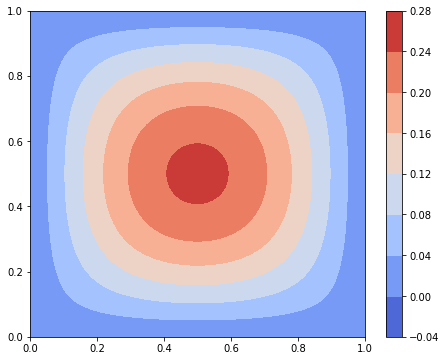

In [3]:
xs = torch.linspace(0, 1, 101)
ys = torch.linspace(0, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ds = cdbc.l_d(xx, yy)
l_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

## The shape of $A_D(x, y)$

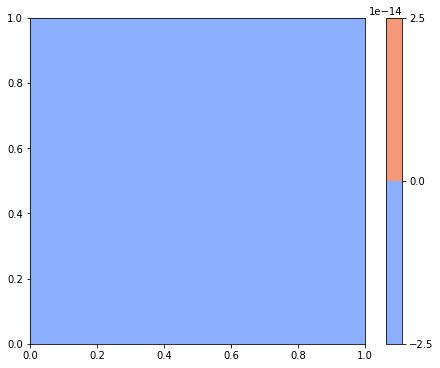

In [4]:
a_ds = cdbc.a_d(xx, yy)
a_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, a_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.ode import IVP, Monitor, solve_system
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
%matplotlib notebook

## This is slow

<IPython.core.display.Javascript object>


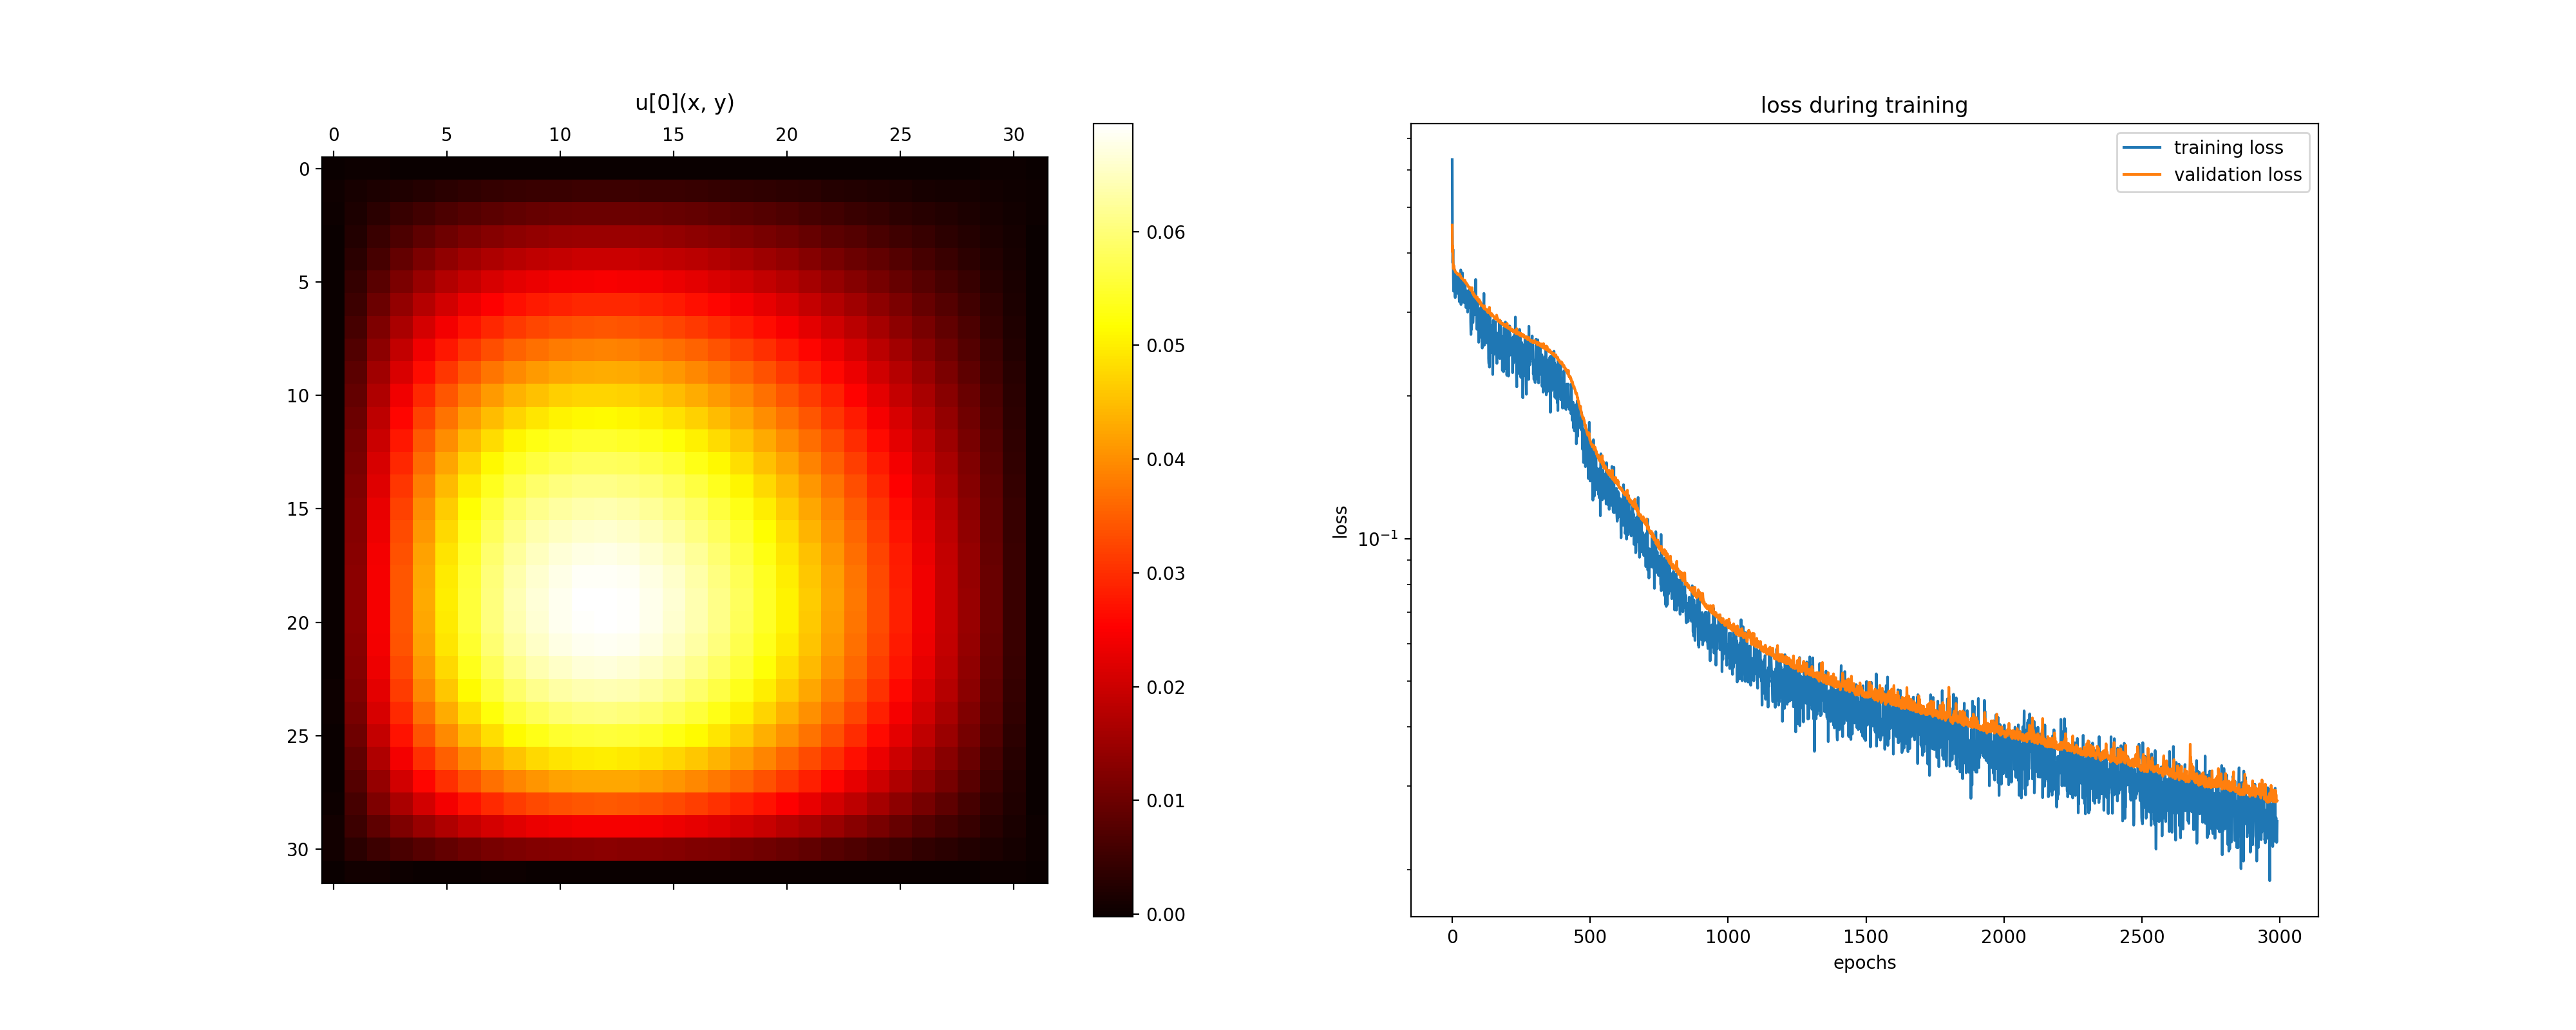

In [6]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 2*x*(y-1)*(y-2*x+x*y+2)*torch.exp(x-y)
bc = cdbc
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(0, 0), xy_max=(1, 1),
    net=net, max_epochs=3000, train_generator=ExampleGenerator2D(
        (32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1)),
    batch_size=256
)
# It is horrobly slow...

In [7]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
solution_analytical_poisson = lambda x, y: np.exp(x-y)*x*(1-x)*y*(1-y)
sol_ana = solution_analytical_poisson(xx, yy)
sol_net = solution_neural_net_poisson(xx, yy, as_type='np')

<IPython.core.display.Javascript object>


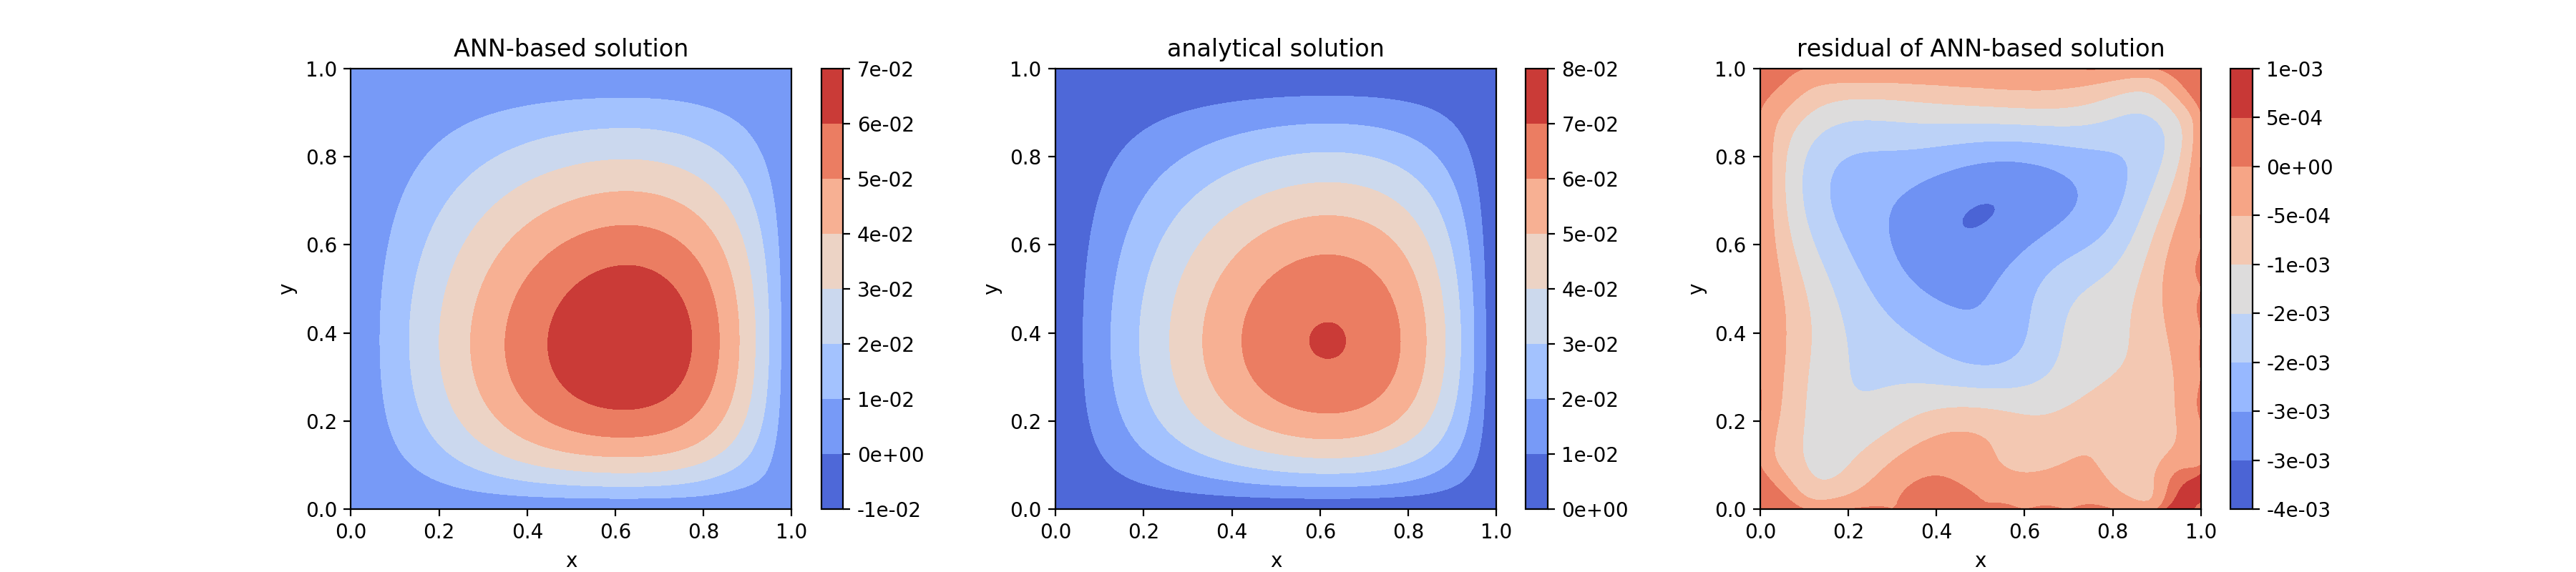

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(18, 4))

ax1 = fig.add_subplot(131)
cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('ANN-based solution')
cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)

ax2 = fig.add_subplot(132)
cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('analytical solution')
cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

ax3 = fig.add_subplot(133)
cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title('residual of ANN-based solution')
cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)